# Анализ тональности отзывов на товары

Цель: **научиться предсказывать тональность (отрицательный или положительный) отзыва по тексту**

Датасет: **Amazon Reviews 2023 / Electronics**

Архитектура: **BERT**

# Libraries import and data loading

In [1]:
# %pip install pandas numpy matplotlib scikit-learn seaborn transformers torch tqdm

import pandas as pd
from datasets import load_dataset
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

In [2]:
def rating_to_sentiment(rating):
    if rating in [1, 2]:
        return 0
    if rating in [4, 5]:
        return 1

dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Electronics", split='full[-400000:]', trust_remote_code=True)

df = dataset.to_pandas()
df

Generating full split: 0 examples [00:00, ? examples/s]

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,It works,"Product works, was sold as new but it really w...",[],B013RI9V7O,B013RI9V7O,AGQGEAP57CSWYC65UMERSO3C7C7A,1565440558264,0,True
1,5.0,it works,Product as advertised,[],B0058CWE68,B0058CWE68,AGQGEAP57CSWYC65UMERSO3C7C7A,1565440493877,0,True
2,5.0,Great Mini PC,This is for the Geekom AS6 6900hx mini pc. I'...,[],B0C16RFWTY,B0C16RFWTY,AFEYDUX7GQYYOCQK2GBB7C76DPUQ,1686009114076,1,True
3,5.0,Great minipc!,Surpasses my expectations so far! Supports pc...,[],B0B3WZN1V1,B0BWF8TTXP,AFEYDUX7GQYYOCQK2GBB7C76DPUQ,1675311755016,0,True
4,5.0,It performs like the specs say,So far so good! Works great. The test was ru...,"[{'attachment_type': 'IMAGE', 'large_image_url...",B0B14QY7MZ,B0B141B4ZL,AFEYDUX7GQYYOCQK2GBB7C76DPUQ,1675311526642,1,True
...,...,...,...,...,...,...,...,...,...,...
399995,5.0,Great little bird,Awesome item. The piece can be worn as a piece...,[],B0055WSPGO,B0055WSPGO,AG6GCWFPTEYFDEC6IFB2CIJGRBZQ,1316823743000,0,True
399996,5.0,Fitbit Sense is for you!!!,Love my Fitbit Sense. I can track my steps an...,[],B08DFLG5SP,B08GLRVD95,AGVM4Q7V5CGR5SRZNW7GTMXQMNDA,1611054754115,0,True
399997,1.0,Cheap,Break easily.,[],B07CPP72N2,B07CPP72N2,AFDKH2CK3YBL2TQXVVGJRZHQJKIQ,1584552634963,0,True
399998,5.0,Five Stars,Great!!,[],B074MPGVYH,B074MPGVYH,AGDC4SOFDQ3UXPXMEYJ57SMM3F4A,1513198400934,0,True


In [3]:
df['sentiment'] = df['rating'].apply(rating_to_sentiment)
df = df.dropna(subset=['sentiment'])
df = df[['text', 'sentiment']]

df['text']

0         Product works, was sold as new but it really w...
1                                     Product as advertised
2         This is for the Geekom AS6 6900hx mini pc.  I'...
3         Surpasses my expectations so far!  Supports pc...
4         So far so good!  Works great.  The test was ru...
                                ...                        
399995    Awesome item. The piece can be worn as a piece...
399996    Love my Fitbit Sense.  I can track my steps an...
399997                                        Break easily.
399998                                              Great!!
399999    We had a JBL prior to getting this one and it ...
Name: text, Length: 375199, dtype: object

In [4]:
df['text'] = df['text'].str.replace('<br />', ' ')

# Data visualization

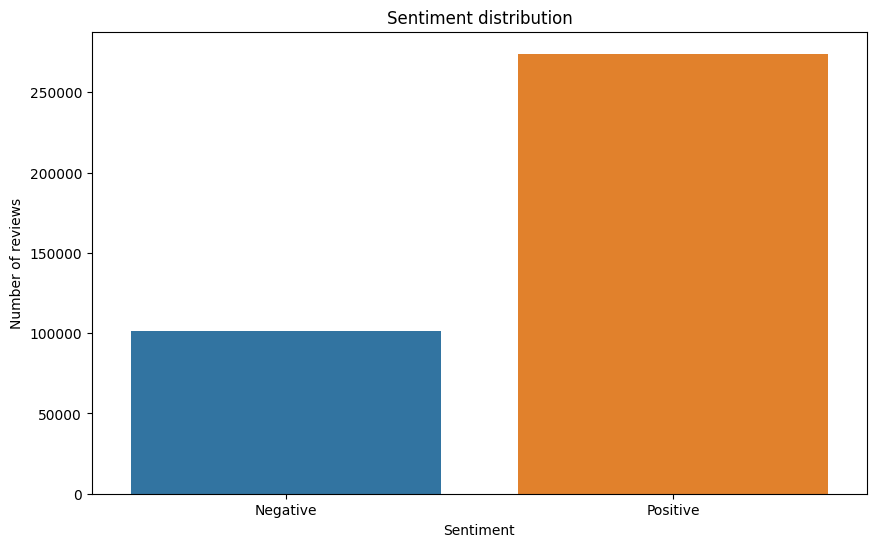

In [5]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment')
plt.title('Sentiment distribution')
plt.xlabel('Sentiment')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.ylabel('Number of reviews')
plt.show()

Выборка несбалансирована, положительных отзывов больше отрицательных, поэтому сделаем downsampling

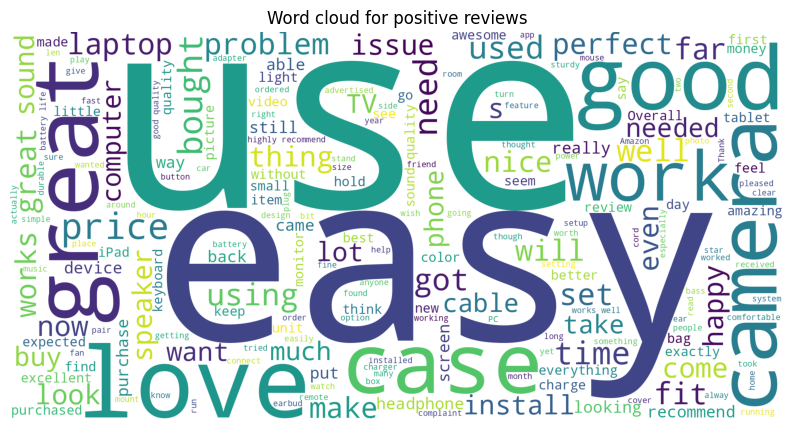

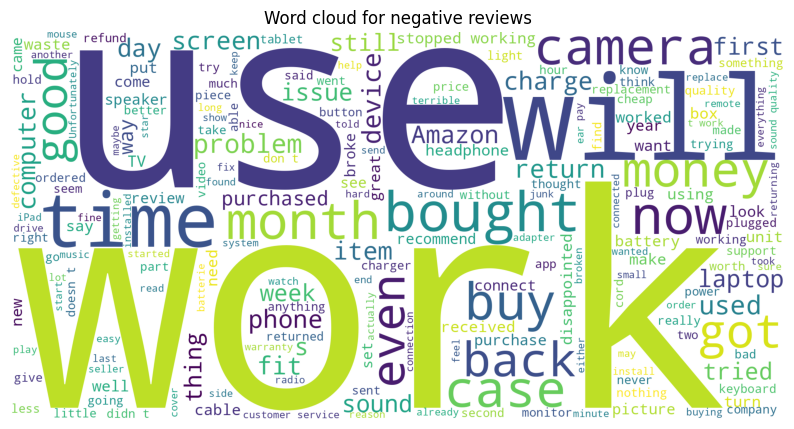

In [6]:
positive_text = "".join(df[df['sentiment'] == 1]['text'])
stopwords = STOPWORDS
stopwords = stopwords.union({'one', 'br', 'product'})
wordcloud = WordCloud(width=2000, height=1000, background_color='white', stopwords=stopwords).generate(positive_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud)
plt.title('Word cloud for positive reviews')
plt.axis('off')
plt.show()

negative_text = "".join(df[df['sentiment'] == 0]['text'])
wordcloud = WordCloud(width=2000, height=1000, background_color='white', stopwords=stopwords).generate(negative_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud)
plt.title('Word cloud for negative reviews')
plt.axis('off')
plt.show()

# Downsampling

In [7]:
count_class_0 = df.groupby('sentiment').size()[0]
class_1_downsampled = df[df['sentiment'] == 1].sample(count_class_0, random_state=42)
class_0_df = df[df['sentiment'] == 0]
df = pd.concat([class_0_df, class_1_downsampled])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(df.groupby('sentiment').size())

X = df['text']
y = df['sentiment']

sentiment
0.0    101144
1.0    101144
dtype: int64


# Dataset and DataLoader classes definition

In [8]:
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

train_texts, test_texts, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)

max_len = 160
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = ReviewDataset(train_texts.values, train_labels.values, tokenizer, max_len)
test_dataset = ReviewDataset(test_texts.values, test_labels.values, tokenizer, max_len)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Model, loss function and optimizer definition

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss().to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Train and evaluation functions

In [10]:
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    losses = []
    correct_predictions = 0

    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        loss = loss_fn(outputs.logits, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

def eval_model(model, data_loader, loss_fn, device):
    model.eval()
    losses = []
    correct_predictions = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            loss = loss_fn(outputs.logits, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = correct_predictions.double() / len(data_loader.dataset)
    mean_loss = np.mean(losses)

    return accuracy.item(), mean_loss, all_preds

# Train loop

In [11]:
epochs = 5
history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
    val_acc, val_loss, val_preds = eval_model(model, test_loader, loss_fn, device)

    history['train_acc'].append(train_acc.item())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    print(f'Train loss {train_loss:.3f} accuracy {train_acc:.3f}')
    print(f'Val   loss {val_loss:.3f} accuracy {val_acc:.3f}')

Epoch 1/5


Evaluating: 100%|██████████| 1265/1265 [04:31<00:00,  4.66it/s]


Train loss 0.139 accuracy 0.950
Val   loss 0.118 accuracy 0.959
Epoch 2/5


Evaluating: 100%|██████████| 1265/1265 [04:33<00:00,  4.63it/s]


Train loss 0.087 accuracy 0.971
Val   loss 0.138 accuracy 0.957
Epoch 3/5


Evaluating: 100%|██████████| 1265/1265 [04:31<00:00,  4.65it/s]


Train loss 0.057 accuracy 0.982
Val   loss 0.150 accuracy 0.956
Epoch 4/5


Evaluating: 100%|██████████| 1265/1265 [04:32<00:00,  4.64it/s]


Train loss 0.042 accuracy 0.987
Val   loss 0.157 accuracy 0.957
Epoch 5/5


Evaluating: 100%|██████████| 1265/1265 [04:34<00:00,  4.62it/s]

Train loss 0.034 accuracy 0.990
Val   loss 0.180 accuracy 0.958


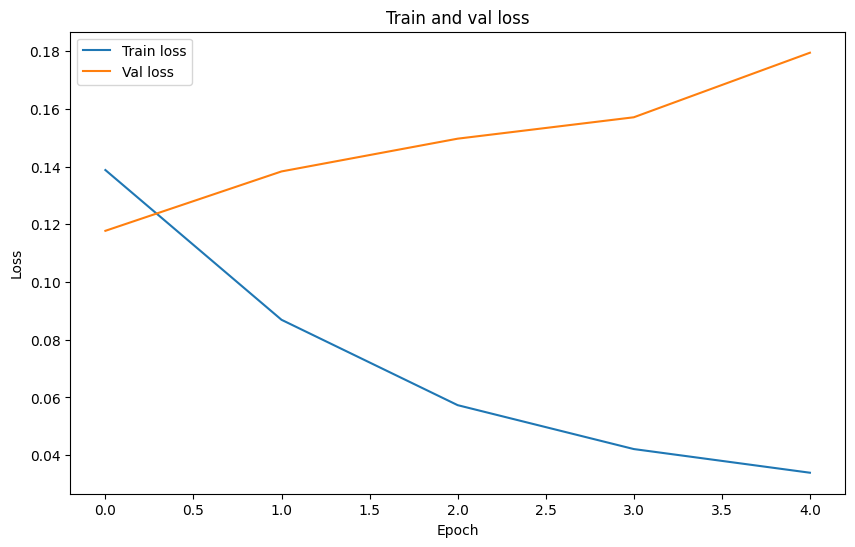

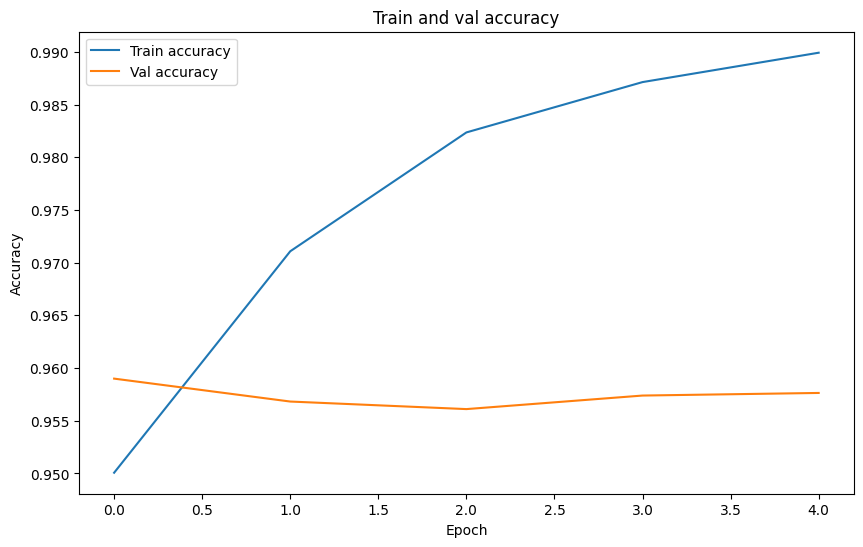

In [12]:
plt.figure(figsize=(10, 6))
sns.lineplot(history['train_loss'], label='Train loss')
sns.lineplot(history['val_loss'], label='Val loss')
plt.title('Train and val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(history['train_acc'], label='Train accuracy')
sns.lineplot(history['val_acc'], label='Val accuracy')
plt.title('Train and val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Model Performance Analysis

In [13]:
test_acc, test_loss, test_preds = eval_model(model, test_loader, loss_fn, device)

print(f'Test loss: {test_loss:.3f} accuracy: {test_acc:.3f}')

Evaluating: 100%|██████████| 1265/1265 [04:34<00:00,  4.62it/s]

Test loss: 0.180 accuracy: 0.958


In [14]:
class_report = classification_report(test_labels, test_preds, target_names=['negative', 'positive'])
print("Classification report:")
print(class_report)

Classification report:
              precision    recall  f1-score   support

    negative       0.95      0.97      0.96     20267
    positive       0.97      0.95      0.96     20191

    accuracy                           0.96     40458
   macro avg       0.96      0.96      0.96     40458
weighted avg       0.96      0.96      0.96     40458



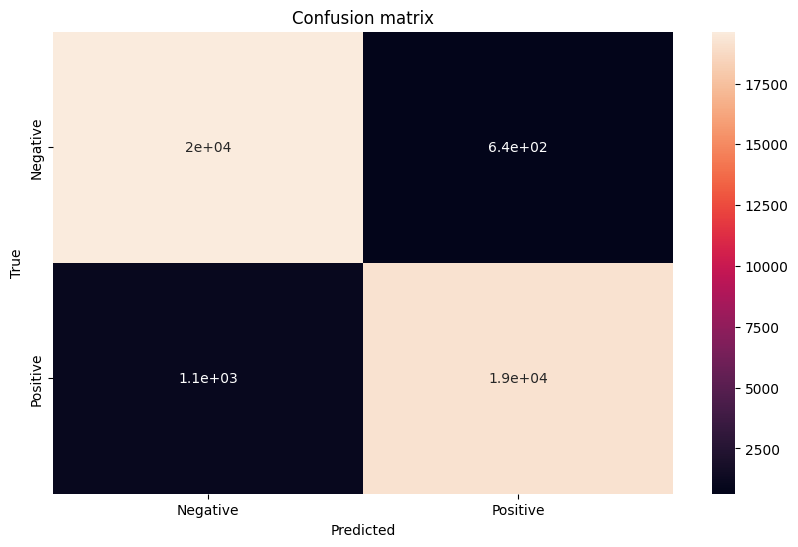

In [15]:
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(test_labels, test_preds), annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()